In [1]:
# Loading necessary libraries
from Bio import SeqIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn import decomposition
#from sklearn_som.som import SOM
import geopandas as gpd
from sklearn.mixture import GaussianMixture
from scipy.special import logit
from sklearn.model_selection import train_test_split
from pykrige.rk import RegressionKriging
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import copy
from sklearn.linear_model import LinearRegression
import matplotlib

In [2]:
### MDM: use all genomic data not subsamble

# Reading in datasets that have already been generated
# genome_covariates.csv is part of code appendix A and includes the individual features for all genomes
# balanced_subsample.csv is part of code appendix D and is the data subset used to generate the regression kriging model
genome_data=pd.read_csv('genome_covariates.csv',index_col=0)
no_malaspina=pd.read_csv('tetramer_gov_only.csv',index_col=0)
abundance=pd.read_table('Normalized_Viral_Abundances_ALL_5kb_noMalaspina.txt',index_col=0)
abundance_nomalaspina = abundance.iloc[:,:131]
normalized_frequencies=np.divide(no_malaspina.T,genome_data['length'].to_numpy()).T
example_genomes=pd.read_csv('../parse/alldata_111821.csv')########################
full_table=genome_data.set_index('ID').join(normalized_frequencies)###########################
#Getting per station data
coordinates = example_genomes.groupby('station_abundance').first()[['latitude','longitude','depth','station_id','level_code','nitrate','temperature','salinity','oxygen']]
# Recalling the number of columns that go before the kmer frequencies
print(full_table.columns[-256:])
# Just making sure we don't miss any

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


Index(['AAAA', 'AAAT', 'AAAC', 'AAAG', 'AATA', 'AATT', 'AATC', 'AATG', 'AACA',
       'AACT',
       ...
       'GGTC', 'GGTG', 'GGCA', 'GGCT', 'GGCC', 'GGCG', 'GGGA', 'GGGT', 'GGGC',
       'GGGG'],
      dtype='object', length=256)


In [19]:
#Calculating relative abundances
relative_abundance = copy.deepcopy(abundance_nomalaspina)
for i in range(0,abundance_nomalaspina.shape[1]):
    relative_abundance.iloc[:,i] = abundance_nomalaspina.iloc[:,i] / sum(abundance_nomalaspina.iloc[:,i])

In [20]:
# Making a table that's numpy-array friendly to use for sklearn
kmers_only=full_table.iloc[:,-256:]
kmers_only
# Mkaing sure I know which columns are in there
full_table.columns[0:100]

Index(['length', 'GC', 'A', 'T', 'G', 'C', 'station', 'depth_class', 'depth',
       'lat', 'lon', 'total_c', 'total_n', 'c_to_n', 'AAAA', 'AAAT', 'AAAC',
       'AAAG', 'AATA', 'AATT', 'AATC', 'AATG', 'AACA', 'AACT', 'AACC', 'AACG',
       'AAGA', 'AAGT', 'AAGC', 'AAGG', 'ATAA', 'ATAT', 'ATAC', 'ATAG', 'ATTA',
       'ATTT', 'ATTC', 'ATTG', 'ATCA', 'ATCT', 'ATCC', 'ATCG', 'ATGA', 'ATGT',
       'ATGC', 'ATGG', 'ACAA', 'ACAT', 'ACAC', 'ACAG', 'ACTA', 'ACTT', 'ACTC',
       'ACTG', 'ACCA', 'ACCT', 'ACCC', 'ACCG', 'ACGA', 'ACGT', 'ACGC', 'ACGG',
       'AGAA', 'AGAT', 'AGAC', 'AGAG', 'AGTA', 'AGTT', 'AGTC', 'AGTG', 'AGCA',
       'AGCT', 'AGCC', 'AGCG', 'AGGA', 'AGGT', 'AGGC', 'AGGG', 'TAAA', 'TAAT',
       'TAAC', 'TAAG', 'TATA', 'TATT', 'TATC', 'TATG', 'TACA', 'TACT', 'TACC',
       'TACG', 'TAGA', 'TAGT', 'TAGC', 'TAGG', 'TTAA', 'TTAT', 'TTAC', 'TTAG',
       'TTTA', 'TTTT'],
      dtype='object')

BIC:
-1593969.3740538962
GMM Means
[[1.26678137]
 [1.35478649]]
GMM Covariance matrix (variances)
[[[0.00059029]]

 [[0.00091652]]]
GMM Mixture Weights
[0.56298644 0.43701356]


AttributeError: module 'seaborn' has no attribute 'histplot'

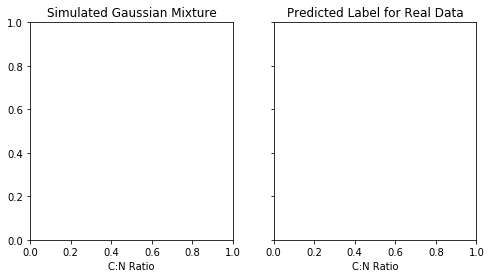

In [35]:
# Generating a GMM to delineate the bimodal distribution of C:N Ratios in the dataset
subpopulation_data=full_table[['c_to_n']].to_numpy()
# Learning the gaussian mixture
nitrogen_mixture=GaussianMixture(n_components=2,random_state=931).fit(subpopulation_data)
# Printing relevant metrics
print('BIC:')
print(nitrogen_mixture.bic(subpopulation_data))
print('GMM Means')
print(nitrogen_mixture.means_)
print('GMM Covariance matrix (variances)')
print(nitrogen_mixture.covariances_)
print('GMM Mixture Weights')
print(nitrogen_mixture.weights_)
# Assigning labels to the dataset
full_table['Distribution']=nitrogen_mixture.predict(full_table.loc[:,'c_to_n'].to_numpy().reshape(-1,1))
# Simulating a sample to compare to real data
points,labels=nitrogen_mixture.sample(full_table.shape[0])
# Plotting Results to Compare Generative Simulation to Observed Data
output_frame=pd.DataFrame(points,columns=['c_to_n'])
output_frame['Distribution']=labels
fig,ax=plt.subplots(1,2,sharey=True)
fig.set_size_inches(8,4)
ax[0].set_title('Simulated Gaussian Mixture')
ax[0].set_xlabel('C:N Ratio')
ax[1].set_title('Predicted Label for Real Data')
ax[1].set_xlabel('C:N Ratio')
sns.histplot(x=output_frame['c_to_n'],hue=output_frame['Distribution'],ax=ax[0],multiple='stack')
sns.histplot(x=full_table['c_to_n'],hue=full_table['Distribution'],ax=ax[1],multiple='stack')

Text(0, 0.5, 'Number of stations')

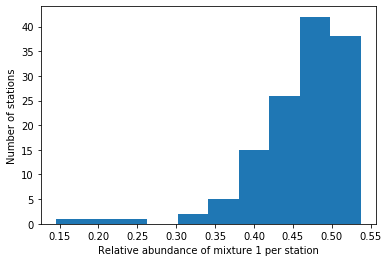

In [36]:
#Presence of mixture 1 per station based on normalized abundances
mean_distr_perstation = []
abundance_and_distr = relative_abundance.join(full_table['Distribution'])
for i in range(0,abundance_and_distr.iloc[:,:-1].shape[1]):
    mean_distr_perstation.append(sum(abundance_and_distr.iloc[:,i] * abundance_and_distr.iloc[:,-1]))
plt.hist(mean_distr_perstation)
plt.xlabel('Relative abundance of mixture 1 per station')
plt.ylabel('Number of stations')

In [42]:
#MDM: SELECTING NUMBER OF GENOMIC SOMs BASED ON K-mers

## Using the tetranucleotide frequencies to learn a map to show the differences in genome composition in a smaller
## dimensional space
kmers_subsample = kmers_only.sample(n=50000)

a = np.zeros([10,10])
stuff = range(2,11)
combs =itertools.combinations_with_replacement(stuff, 2)
for subset in combs:
    m=subset[0]
    n=subset[1]
    print('='*40)
    print('dimensions = [',m,',',n,']')
    kmer_som=SOM(m,n,dim=np.shape(kmers_subsample)[1])
    print('Learning som')
    kmer_som.fit(kmers_subsample.to_numpy())
    print('Labeling with som')
    cluster_prediction=kmer_som.predict(kmers_subsample.to_numpy())
    print('Scoring som')
        #sample_silhouette_values = silhouette_samples(kmers_only, cluster_prediction)
    avg_silhouette_score = silhouette_score(kmers_subsample, cluster_prediction)
    print('Average silhouette score:', avg_silhouette_score)
    a[m-1,n-1] = avg_silhouette_score
    
b = pd.DataFrame(data=a.astype(float))
b.to_csv('som_scores.csv', header=False, float_format='%.4f', index=False)

dimensions = [ 2 , 2 ]
Learning som
Labeling with som
Scoring som
Average silhouette score: 0.17014759611977937
dimensions = [ 2 , 3 ]
Learning som
Labeling with som
Scoring som
Average silhouette score: 0.1113207786568201
dimensions = [ 2 , 4 ]
Learning som
Labeling with som
Scoring som
Average silhouette score: 0.08451045483598375
dimensions = [ 2 , 5 ]
Learning som
Labeling with som
Scoring som
Average silhouette score: 0.06386614094129096
dimensions = [ 2 , 6 ]
Learning som
Labeling with som
Scoring som
Average silhouette score: 0.05972448649832343
dimensions = [ 2 , 7 ]
Learning som
Labeling with som
Scoring som
Average silhouette score: 0.06018676245919106
dimensions = [ 2 , 8 ]
Learning som
Labeling with som
Scoring som
Average silhouette score: 0.051660878354580865
dimensions = [ 2 , 9 ]
Learning som
Labeling with som
Scoring som
Average silhouette score: 0.046742439159612244
dimensions = [ 2 , 10 ]
Learning som
Labeling with som
Scoring som
Average silhouette score: 0.04508257

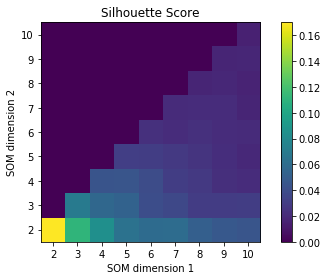

In [15]:
b = pd.read_csv('som_scores.csv',header=None)
a = np.array(b)
fig, ax = plt.subplots()
im = ax.imshow(a[1:11,1:11])
ax.invert_yaxis()
ax.set_xticks(range(0,9))
ax.set_xticklabels(range(2,11))
ax.set_yticks(range(0,9))
ax.set_yticklabels(range(2,11))
ax.set_title("Silhouette Score")
plt.xlabel('SOM dimension 1')
plt.ylabel('SOM dimension 2')
plt.colorbar(im)
fig.tight_layout()
plt.show()

In [162]:
##DONT RUN THIS USE FILE
kmer_som=SOM(2,2,dim=np.shape(kmers_only)[1])
print('Learning som')
kmer_som.fit(kmers_only.to_numpy())
print('Labeling with som')
cluster_prediction=kmer_som.predict(kmers_only.to_numpy())
#Assign to corresponding genome
full_table['SOM']=cluster_prediction
full_table.to_csv('full_table.csv')

Learning som
Labeling with som


([], <a list of 0 Text xticklabel objects>)

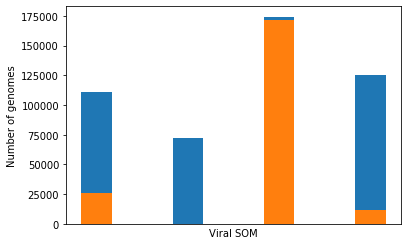

In [27]:
SOM_dist = pd.read_csv('Dist_SOM.csv',index_col=0)
a = SOM_dist[SOM_dist['Distribution']==0]
b = SOM_dist[SOM_dist['Distribution']==1]
plt.hist(data=tmp,x='SOM',stacked=True)
plt.hist(data=b,x='SOM',stacked=True)
plt.xlabel('Viral SOM')
plt.ylabel('Number of genomes')
plt.xticks([])

In [37]:
#Proportion of each SOM (Viral Group) per station
df = pd.DataFrame()
tmp = relative_abundance.join(SOM_dist['SOM'])
for i in set(tmp['SOM']):
    df['VG'+str(i)]=tmp[tmp['SOM']==i].iloc[:,:-1].sum(axis=0)
    
#Calculating weighted mean of c to n per station
abundance_and_cton = relative_abundance.join(full_table['c_to_n'])
df['c_to_n']=0
for i in range(0,abundance_and_cton.iloc[:,:-1].shape[1]):
    df.loc[abundance_and_cton.columns[i],'c_to_n']=sum(abundance_and_distr.iloc[:,i] * abundance_and_cton.iloc[:,-1])
    
#df.to_csv('som_perstation_and_cton.csv', header=True, index=True)

In [252]:
#predicting c to n per genome using SOM classification
#There are NaNs somewhere
tmp = full_table[-full_table.isnull().any(axis=1)].sample(n=10000)
target = tmp['c_to_n']
#covar = tmp[['Distribution','SOM','length','depth']]
covar = tmp[['SOM']]
coord = tmp[['lat','lon']]

cov_train, cov_test, coord_train, coord_test, target_train, target_test = train_test_split(
    covar, coord, target, test_size=0.3, random_state=42)
# This time because we have a mix of categorical variables and continuous variables with different bounds,
# instead of using a linear model we will use a random forest
regression_model=RandomForestRegressor(random_state=7645) 

m_rk = RegressionKriging(regression_model = regression_model, n_closest_points = 5, coordinates_type = 'geographic', variogram_model = 'gaussian')
m_rk.fit(cov_train.iloc[:,:].values, coord_train.iloc[:,:].values, target_train.iloc[:].values)
print("Regression Score (R^2): ", m_rk.regression_model.score(cov_test, target_test))
rk_score = m_rk.score(cov_test.iloc[:,:].values, coord_test.iloc[:,:].values, target_test.iloc[:].values)
print("RK score (R^2): ", rk_score)
print("RK Mean Squared Error: ", mean_squared_error(y_true = target_test.iloc[:].values, y_pred = m_rk.predict(cov_test.iloc[:,:].values, coord_test.iloc[:,:].values)))
predictions =  m_rk.predict(cov_test.iloc[:,:].values, coord_test.iloc[:,:].values)

Finished learning regression model
Finished kriging residuals
Regression Score (R^2):  0.8117293088438343
RK score (R^2):  0.7712297974415279
RK Mean Squared Error:  0.0006067234369051618


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Regression score: 0.891125574232728


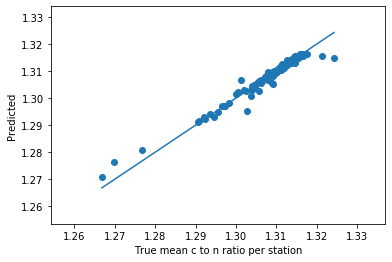

In [106]:
# Predicting mean C to N per station using the SOM relative abundance per station
df = pd.read_csv('som_perstation_and_cton.csv',index_col=0)
target = np.array(df['c_to_n'])
covar = df[['VG0','VG1','VG2','VG3']]

cov_train, cov_test, target_train, target_test = train_test_split(
    covar, target, test_size=0.3, random_state=42)
regression_model=RandomForestRegressor(random_state=7645) 
regression_model.fit(cov_train,target_train.reshape(-1, 1))
score = regression_model.score(cov_test,target_test.reshape(-1, 1))
pred = regression_model.predict(covar)
plt.scatter(target,pred)
plt.xlabel('True mean c to n ratio per station')
plt.ylabel('Predicted')
plt.plot([min(target),max(target)],[min(target),max(target)])
print('Regression score:', score)

Text(0.5, 1.0, 'Inertia across cluster number')

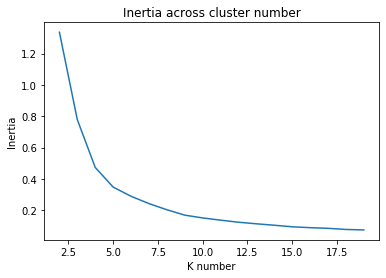

In [45]:
#Choosing number of kmean groups for station clustering based in viral group
df2 = df.join(coordinates)
X=df2[['VG0','VG1','VG2','VG3']]
ss = []
for k in range(2,20):
    #print('='*40)
    #print('K = ',k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    avg_silhouette_score = silhouette_score(X, kmeans.labels_)
    #print('Average silhouette score:', avg_silhouette_score)
    #ss.append(avg_silhouette_score)
    ss.append(kmeans.inertia_)
plt.plot(range(2,20),ss)
plt.xlabel('K number')
plt.ylabel('Inertia')
plt.title('Inertia across cluster number')

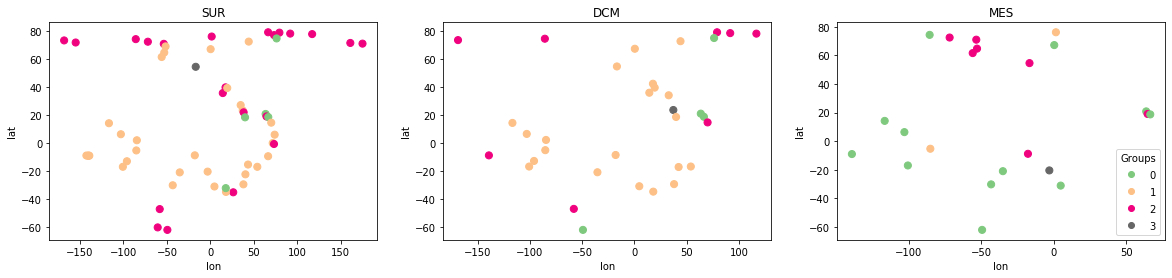

In [81]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(X)
df2['kmeans'] = kmeans.labels_
color = "Accent"
fig = plt.gcf()
fig.set_size_inches(20, 4)
plt.subplot(1,3,1)
ss1 = df2[df2['level_code'] == 'SUR']
plt.scatter(ss1['longitude'],ss1['latitude'],c=ss1['kmeans'],cmap=color,s=50)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('SUR')
plt.subplot(1,3,2)
ss1 = df2[df2['level_code'] == 'DCM']
plt.scatter(ss1['longitude'],ss1['latitude'],c=ss1['kmeans'],cmap=color,s=50)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('DCM')
plt.subplot(1,3,3)
ss1 = df2[df2['level_code'] == 'MES']
scatter = plt.scatter(ss1['longitude'],ss1['latitude'],c=ss1['kmeans'],cmap=color,s=50)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('MES')
handles, labels = scatter.legend_elements(prop="colors", alpha=1)
legend2 = plt.legend(handles, labels, loc="lower right", title="Groups")
#df2.to_csv('stationgroup.csv',header=True,index=True)

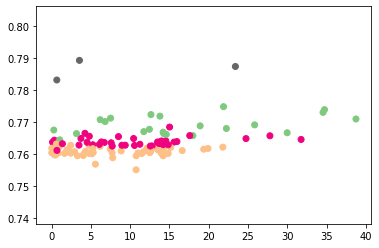

In [11]:
df2 = pd.read_csv('stationgroup.csv',index_col=0)
plt.scatter(df2['nitrate'],1/df2['c_to_n'],c=df2['kmeans'],cmap='Accent')

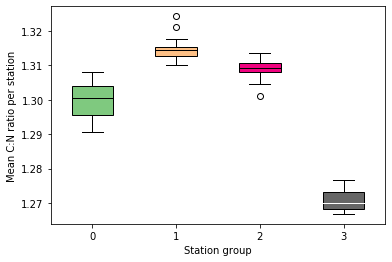

In [176]:
cmap = matplotlib.cm.get_cmap('Accent')
g0 = plt.boxplot(list(df2[df2['kmeans']==0]['c_to_n']),patch_artist=1,positions=[0],widths=(0.5),medianprops= dict(color="black"))
g1 = plt.boxplot(list(df2[df2['kmeans']==1]['c_to_n']),patch_artist=1,positions=[1],widths=(0.5),medianprops= dict(color="black"))
g2 = plt.boxplot(list(df2[df2['kmeans']==2]['c_to_n']),patch_artist=1,positions=[2],widths=(0.5),medianprops= dict(color="black"))
g3 = plt.boxplot(list(df2[df2['kmeans']==3]['c_to_n']),patch_artist=1,positions=[3],widths=(0.5),medianprops= dict(color="white"))
# change fill color
for box in g0['boxes']:
    box.set(facecolor = cmap(0))
for box in g1['boxes']:
    box.set(facecolor = cmap(2) )
for box in g2['boxes']:
    box.set(facecolor = cmap(5) )
for box in g3['boxes']:
    box.set(facecolor = cmap(7) )
plt.xlabel('Station group')
plt.ylabel('Mean C:N ratio per station')
plt.show()

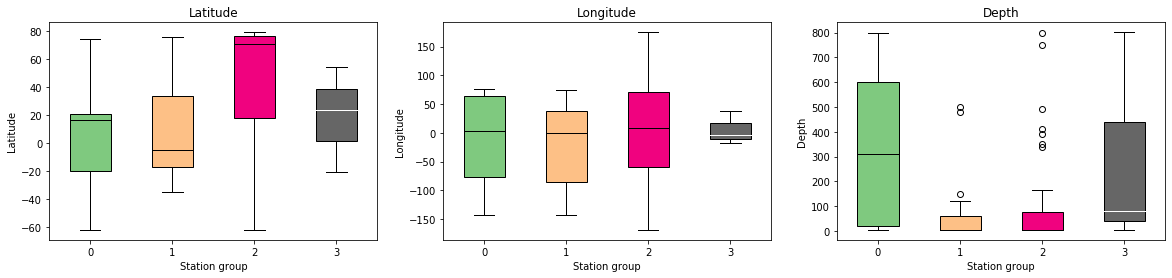

In [197]:
gl = df2[-df2.isnull().any(axis=1)]
fig = plt.gcf()
fig.set_size_inches(20, 4)

#Latitude
plt.subplot(1,3,1)
g0 = plt.boxplot(list(gl[gl['kmeans']==0]['latitude']),patch_artist=1,positions=[0],widths=(0.5),medianprops= dict(color="black"))
g1 = plt.boxplot(list(gl[gl['kmeans']==1]['latitude']),patch_artist=1,positions=[1],widths=(0.5),medianprops= dict(color="black"))
g2 = plt.boxplot(list(gl[gl['kmeans']==2]['latitude']),patch_artist=1,positions=[2],widths=(0.5),medianprops= dict(color="black"))
g3 = plt.boxplot(list(gl[gl['kmeans']==3]['latitude']),patch_artist=1,positions=[3],widths=(0.5),medianprops= dict(color="white"))
# change fill color
for box in g0['boxes']:
    box.set(facecolor = cmap(0))
for box in g1['boxes']:
    box.set(facecolor = cmap(2) )
for box in g2['boxes']:
    box.set(facecolor = cmap(5) )
for box in g3['boxes']:
    box.set(facecolor = cmap(7) )
plt.xlabel('Station group')
plt.ylabel('Latitude')
plt.title('Latitude')

#Longitude
plt.subplot(1,3,2)
g0 = plt.boxplot(list(gl[gl['kmeans']==0]['longitude']),patch_artist=1,positions=[0],widths=(0.5),medianprops= dict(color="black"))
g1 = plt.boxplot(list(gl[gl['kmeans']==1]['longitude']),patch_artist=1,positions=[1],widths=(0.5),medianprops= dict(color="black"))
g2 = plt.boxplot(list(gl[gl['kmeans']==2]['longitude']),patch_artist=1,positions=[2],widths=(0.5),medianprops= dict(color="black"))
g3 = plt.boxplot(list(gl[gl['kmeans']==3]['longitude']),patch_artist=1,positions=[3],widths=(0.5),medianprops= dict(color="white"))
# change fill color
for box in g0['boxes']:
    box.set(facecolor = cmap(0))
for box in g1['boxes']:
    box.set(facecolor = cmap(2) )
for box in g2['boxes']:
    box.set(facecolor = cmap(5) )
for box in g3['boxes']:
    box.set(facecolor = cmap(7) )
plt.xlabel('Station group')
plt.ylabel('Longitude')
plt.title('Longitude')
    
#Depth
plt.subplot(1,3,3)
g0 = plt.boxplot(list(gl[gl['kmeans']==0]['depth']),patch_artist=1,positions=[0],widths=(0.5),medianprops= dict(color="black"))
g1 = plt.boxplot(list(gl[gl['kmeans']==1]['depth']),patch_artist=1,positions=[1],widths=(0.5),medianprops= dict(color="black"))
g2 = plt.boxplot(list(gl[gl['kmeans']==2]['depth']),patch_artist=1,positions=[2],widths=(0.5),medianprops= dict(color="black"))
g3 = plt.boxplot(list(gl[gl['kmeans']==3]['depth']),patch_artist=1,positions=[3],widths=(0.5),medianprops= dict(color="white"))
# change fill color
for box in g0['boxes']:
    box.set(facecolor = cmap(0))
for box in g1['boxes']:
    box.set(facecolor = cmap(2) )
for box in g2['boxes']:
    box.set(facecolor = cmap(5) )
for box in g3['boxes']:
    box.set(facecolor = cmap(7) )
plt.xlabel('Station group')
plt.ylabel('Depth')
plt.title('Depth')

plt.show()

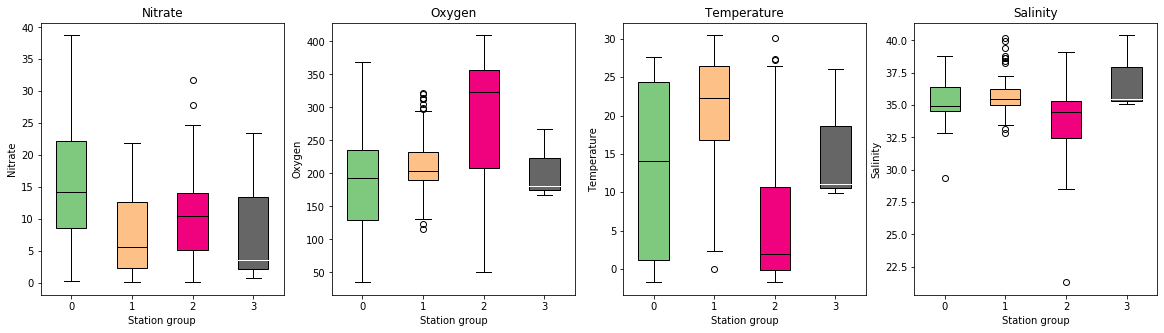

In [221]:
#Environmental features
fig = plt.gcf()
fig.set_size_inches(20, 5)

#Nitrate
plt.subplot(1,4,1)
g0 = plt.boxplot(list(gl[gl['kmeans']==0]['nitrate']),patch_artist=1,positions=[0],widths=(0.5),medianprops= dict(color="black"))
g1 = plt.boxplot(list(gl[gl['kmeans']==1]['nitrate']),patch_artist=1,positions=[1],widths=(0.5),medianprops= dict(color="black"))
g2 = plt.boxplot(list(gl[gl['kmeans']==2]['nitrate']),patch_artist=1,positions=[2],widths=(0.5),medianprops= dict(color="black"))
g3 = plt.boxplot(list(gl[gl['kmeans']==3]['nitrate']),patch_artist=1,positions=[3],widths=(0.5),medianprops= dict(color="white"))
# change fill color
for box in g0['boxes']:
    box.set(facecolor = cmap(0))
for box in g1['boxes']:
    box.set(facecolor = cmap(2) )
for box in g2['boxes']:
    box.set(facecolor = cmap(5) )
for box in g3['boxes']:
    box.set(facecolor = cmap(7) )
plt.xlabel('Station group')
plt.ylabel('Nitrate')
plt.title('Nitrate')

#Oxygen
plt.subplot(1,4,2)
g0 = plt.boxplot(list(gl[gl['kmeans']==0]['oxygen']),patch_artist=1,positions=[0],widths=(0.5),medianprops= dict(color="black"))
g1 = plt.boxplot(list(gl[gl['kmeans']==1]['oxygen']),patch_artist=1,positions=[1],widths=(0.5),medianprops= dict(color="black"))
g2 = plt.boxplot(list(gl[gl['kmeans']==2]['oxygen']),patch_artist=1,positions=[2],widths=(0.5),medianprops= dict(color="black"))
g3 = plt.boxplot(list(gl[gl['kmeans']==3]['oxygen']),patch_artist=1,positions=[3],widths=(0.5),medianprops= dict(color="white"))
# change fill color
for box in g0['boxes']:
    box.set(facecolor = cmap(0))
for box in g1['boxes']:
    box.set(facecolor = cmap(2) )
for box in g2['boxes']:
    box.set(facecolor = cmap(5) )
for box in g3['boxes']:
    box.set(facecolor = cmap(7) )
plt.xlabel('Station group')
plt.ylabel('Oxygen')
plt.title('Oxygen')
    
#Temperature
plt.subplot(1,4,3)
g0 = plt.boxplot(list(gl[gl['kmeans']==0]['temperature']),patch_artist=1,positions=[0],widths=(0.5),medianprops= dict(color="black"))
g1 = plt.boxplot(list(gl[gl['kmeans']==1]['temperature']),patch_artist=1,positions=[1],widths=(0.5),medianprops= dict(color="black"))
g2 = plt.boxplot(list(gl[gl['kmeans']==2]['temperature']),patch_artist=1,positions=[2],widths=(0.5),medianprops= dict(color="black"))
g3 = plt.boxplot(list(gl[gl['kmeans']==3]['temperature']),patch_artist=1,positions=[3],widths=(0.5),medianprops= dict(color="white"))
# change fill color
for box in g0['boxes']:
    box.set(facecolor = cmap(0))
for box in g1['boxes']:
    box.set(facecolor = cmap(2) )
for box in g2['boxes']:
    box.set(facecolor = cmap(5) )
for box in g3['boxes']:
    box.set(facecolor = cmap(7) )
plt.xlabel('Station group')
plt.ylabel('Temperature')
plt.title('Temperature')

#Salinity
plt.subplot(1,4,4)
g0 = plt.boxplot(list(gl[gl['kmeans']==0]['salinity']),patch_artist=1,positions=[0],widths=(0.5),medianprops= dict(color="black"))
g1 = plt.boxplot(list(gl[gl['kmeans']==1]['salinity']),patch_artist=1,positions=[1],widths=(0.5),medianprops= dict(color="black"))
g2 = plt.boxplot(list(gl[gl['kmeans']==2]['salinity']),patch_artist=1,positions=[2],widths=(0.5),medianprops= dict(color="black"))
g3 = plt.boxplot(list(gl[gl['kmeans']==3]['salinity']),patch_artist=1,positions=[3],widths=(0.5),medianprops= dict(color="white"))
# change fill color
for box in g0['boxes']:
    box.set(facecolor = cmap(0))
for box in g1['boxes']:
    box.set(facecolor = cmap(2) )
for box in g2['boxes']:
    box.set(facecolor = cmap(5) )
for box in g3['boxes']:
    box.set(facecolor = cmap(7) )
plt.xlabel('Station group')
plt.ylabel('Salinity')
plt.title('Salinity')

plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Regression score: 0.9937536920203656


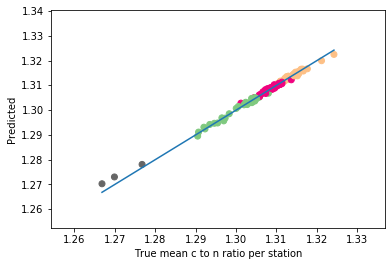

In [132]:
# Predicting mean C to N per station using the SOM relative abundance per station
target = np.array(df2['c_to_n'])
covar = df2[['VG0','VG1','VG2','VG3']]

cov_train, cov_test, target_train, target_test = train_test_split(
    covar, target, test_size=0.3, random_state=42)
regression_model=RandomForestRegressor(random_state=7645) 
regression_model.fit(covar,target.reshape(-1, 1))
score = regression_model.score(cov_test,target_test.reshape(-1, 1))
pred = regression_model.predict(covar)
plt.scatter(target,pred,c=df2['kmeans'],cmap="Accent")
plt.xlabel('True mean c to n ratio per station')
plt.ylabel('Predicted')
plt.plot([min(target),max(target)],[min(target),max(target)])
print('Regression score:', score)

In [214]:
# Predicting mean C to N per station using the SOM relative abundance per station
tmp = df2[-df2.isnull().any(axis=1)]
target = tmp[['c_to_n']]
covar = tmp[['nitrate','temperature','salinity','oxygen','depth']]
coord = tmp[['latitude','longitude']]
#covar = tmp[['nitrate','temperature','salinity','oxygen']]

cov_train, cov_test, coord_train, coord_test, target_train, target_test = train_test_split(
    covar, coord, target, test_size=0.3, random_state=42)
#regression_model=RandomForestRegressor(random_state=7645) 
regression_model=LinearRegression()
#chalala = regression_model.fit(covar,target.reshape(-1, 1))
#score = regression_model.score(cov_test,target_test.reshape(-1, 1))
#pred = regression_model.predict(covar)


m_rk = RegressionKriging(regression_model = regression_model, n_closest_points = 5, coordinates_type = 'geographic', variogram_model = 'gaussian')
m_rk.fit(cov_train, coord_train, target_train.iloc[:].values)
print("Regression Score (R^2): ", m_rk.regression_model.score(cov_test, target_test))
rk_score = m_rk.score(cov_test.iloc[:,:].values, coord_test.iloc[:,:].values, target_test.iloc[:].values)
print("RK score (R^2): ", rk_score)

plt.scatter(target,pred,c=tmp['kmeans'],cmap="Accent")
plt.xlabel('True mean c to n ratio per station')
plt.ylabel('Predicted')
plt.plot([min(target),max(target)],[min(target),max(target)])
print(score)

Finished learning regression model


TypeError: '(slice(None, None, None), 0)' is an invalid key